In [42]:
import random
import re
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from textblob import Word
import pandas as pd
import string as st
from nltk import PorterStemmer, WordNetLemmatizer
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import nltk

nltk.download('all')

# Data Exploration

In [66]:
df = pd.read_csv('./datasets/profile_dataset2.csv')

In [67]:
print(df.shape)

(2440, 2)


In [68]:
# Total type of unique categories
print("Unique categories:",df['type'].unique())

Unique categories: ['business' 'entertainment' 'politics' 'sport' 'tech']


In [69]:
df = df.drop_duplicates()

In [70]:
# Information about metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2342 entries, 0 to 2439
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    2342 non-null   object
 1   type    2342 non-null   object
dtypes: object(2)
memory usage: 54.9+ KB


In [ ]:
report = ProfileReport(df)
report

In [ ]:
# Top categories by and number of articles per categories
cat_df = pd.DataFrame(df['type'].value_counts()).reset_index()
cat_df.rename(columns={'index':'news_classes','type':'numcat'}, inplace=True)

plt.figure(figsize=(10,8))
ax = sns.barplot(np.array(cat_df.news_classes)[:5], np.array(cat_df.numcat)[:5])
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.01, p.get_height() + 8))
plt.title("TOP 5 Categories of News Articles", size=15)
plt.xlabel("Categories of articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)
plt.show()

<AxesSubplot:xlabel='type', ylabel='count'>

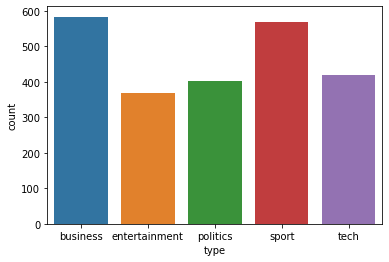

In [73]:
sns.countplot(x='type', data=df)

# Text cleaning and dataset preparation

In [74]:
def remove_punct(text):
    return ("".join([ch for ch in text if ch not in st.punctuation]))

def clean_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    #text = text.translate(str.maketrans('', '', st.punctuation))
    text = remove_punct(text)

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Apply PorterStemmer
    #porter_stemmer = PorterStemmer()
    #tokens = [porter_stemmer.stem(word) for word in tokens]

    # Apply WordNetLemmatizer
    #wordnet_lemmatizer = WordNetLemmatizer()
    #tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens]

    # Join the tokens back into a single string
    clean_text = ' '.join(tokens)

    return clean_text.strip()

In [75]:
def prepare_dataset(dataset):
    #Divide in features and labels. We're gonna do a tokenization and lemmatization process with the news features
    x = df['news'].tolist()
    y = df['type'].tolist()
    wordnet_lemmatizer = WordNetLemmatizer()
    print("Data preparation")
    print("Tokenization and Lemmatization process", end='', flush=True)
    for i, value in enumerate(x):
        x[i] = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in clean_text(value).split()])
        
    
    #Train and test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
    vect = TfidfVectorizer(min_df=2)

    #Training process
    X_train = vect.fit_transform(X_train)
    y_train = np.array(y_train)
    X_test = vect.transform(X_test)
    y_test = np.array(y_test)

    #Train and test split with the vector
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

    print("\n")
    print("Train set:" + str(X_train.shape))
    print("Validation set:" + str(X_val.shape))
    print("Test set:" + str(X_test.shape))

    return X_train, X_val, X_test, y_train, y_val, y_test, vect

# Process for knowing how many neighbors we may use in the K-neighbors

In [79]:
#dataset2 = pd.read_csv('./datasets/profile_dataset2.csv', encoding="ISO-8859-1")
y = df['type'] #Variable objetivo a predecir
X = df.drop("type", axis = 1) #Quitar la columna de vehicle_class
X_train, X_val, X_test, y_train, y_val, y_test, vect = prepare_dataset(df)

Data preparation
Tokenization and Lemmatization process

Train set:(1873, 14656)
Validation set:(234, 14656)
Test set:(235, 14656)


In [80]:
#Process for knowing how many neighbors we may use
error_rate = []
for x in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=x)
    knn.fit(X_train, y_train)
    predictions_x = knn.predict(X_test)
    #Agregar la media de los valores que encuentre diferente entre las predicciones y el valor real. 
    error_rate.append(np.mean(predictions_x != y_test))
    
error_rate

[0.6510638297872341,
 0.08085106382978724,
 0.10638297872340426,
 0.08085106382978724,
 0.07659574468085106,
 0.07659574468085106,
 0.06808510638297872,
 0.06808510638297872,
 0.07659574468085106,
 0.0851063829787234,
 0.08936170212765958,
 0.08936170212765958,
 0.08936170212765958,
 0.07659574468085106,
 0.0851063829787234,
 0.08085106382978724,
 0.06808510638297872,
 0.07234042553191489,
 0.07234042553191489,
 0.07659574468085106,
 0.06808510638297872,
 0.06808510638297872,
 0.06808510638297872,
 0.06382978723404255,
 0.06808510638297872,
 0.07659574468085106,
 0.08085106382978724,
 0.07234042553191489,
 0.08085106382978724]

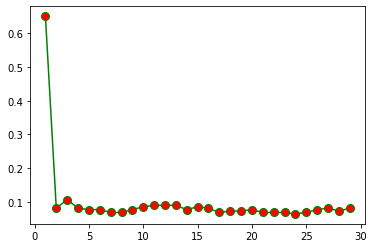

In [81]:
values = range(1,30)
plt.plot(values, error_rate, color = "green", marker="o", markerfacecolor="red", markersize=8)

# Models functions

In [95]:
def NN_train_model(X_train, y_train):
    print("\nNeural Network")
    model = MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=True,
              epsilon=1e-08, hidden_layer_sizes=(128, 64),
              learning_rate='constant', learning_rate_init=0.001,
              max_iter=400, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=1,
              shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
    model.fit(X_train, y_train)
    return model

def RF_train_model(X_train, y_train):
    print("\nRandom Forest")
    model = RandomForestClassifier(n_estimators=200, max_depth=150, n_jobs=1)
    model.fit(X_train, y_train)
    return model

def SVC_train_model(X_train, y_train):
    print("\nSuport Vector Machine")
    model = SVC(kernel='linear', gamma='auto')
    model.fit(X_train, y_train)
    return model

def KN_train_model(X_train, y_train):
    print("\nK Neighbor")
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    return model

def evaluation_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    result = classification_report(y_val, y_pred)
    acc = accuracy_score(y_val, y_pred)
    print(result)
    print("\nAccuracy: ", acc)


def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc




# Set users preferences

In [96]:
topics = ["sport", "tech", "business", "politics", "entertainment"]

# Set preferences by users
def set_preferences(users):
    user_preferences = {}
    for user in users:
        preferences = []
        possibilities = list(topics)
        for pref in range(random.randint(1, 3)):
            category = random.choice(possibilities)
            preferences.append(category)
            possibilities.remove(category)
        user_preferences[user] = preferences
    return user_preferences

# Predict the document type
def predict_doc_type(doc, vect, model):
    document_cleaned = clean_text(doc)
    corpus = []
    corpus.append(document_cleaned)
    test_vect = vect.transform(corpus)
    return model.predict(test_vect)[0]


# Testing results
def run_test(vect, model):
    users = ["Gabriela", "Pablo", "Erick", "Marco", "Sam", "Luis"]
    users_preferences = set_preferences(users)
    print("\n")
    print("User preferences:")
    for user in users_preferences:
        print(user, "likes these topics:", users_preferences[user])
    print("\n")

    while True:
        try:
            test_corpus = input("Enter a text about a specific tpic. If you wanna quit, please press 'e' or if you wanna reassign the preferences please press 'a':\n")
        except ValueError:
            continue
        if test_corpus == "e":
            break
        if test_corpus == "a":
            users_preferences = set_preferences(users)
            print("\n")
            print("User preferences:")
            for user in users_preferences:
                print(user, "likes these topics:", users_preferences[user])
            print("\n")
            continue
            
        else:

            result = predict_doc_type(test_corpus, vect, model)
            if (result == "sport"):
                topic = result.upper()
            if (result == "tech"):
                topic = result.upper()
            if(result == "business"):
                topic = result.upper()
            if (result == "entertainment"):
                topic = result.upper()
            if (result == "politics"):
                topic = result.upper()
            print("\n")
            print("This article talks about "+ topic + " " + "and it's addressed to:")
            for user in users_preferences:
                if result in users_preferences[user]:
                    print(user)
            continue

In [97]:
def test_project():
    # Load dataset and data preparation
    #df = pd.read_csv('./datasets/profile_dataset2.csv', encoding="ISO-8859-1")
    print("Data", df.shape)
    X_train, X_val, X_test, y_train, y_val, y_test, vect = prepare_dataset(df)

    # Models training
    print("\n")
    print("Models Training")
    
    # Suport Vector Machine
    svc_model = SVC_train_model(X_train, y_train)
    evaluation_model(svc_model, X_val, y_val)
    # Random Forest
    rf_model = RF_train_model(X_train, y_train)
    evaluation_model(rf_model, X_val, y_val)
    # Neural Network
    nn_model = NN_train_model(X_train, y_train)
    evaluation_model(nn_model, X_val, y_val)
    # K Neighbor
    kn_model = KN_train_model(X_train, y_train)
    evaluation_model(kn_model, X_val, y_val)


    # Models testing
    print("\n")
    print("Models testing\n")
    print("Suport Vector Machine:", test_model(svc_model, X_test, y_test))
    print("Random Forest:", test_model(rf_model, X_test, y_test))
    print("Neural Network:", test_model(nn_model, X_test, y_test))
    print("K Neighbors:", test_model(kn_model, X_test, y_test))


    # Run test
    #We pass the vector and any model we have trained
    run_test(vect, svc_model)


In [ ]:
test_project()